## Imports and Load cloud

In [3]:
import numpy as np
import open3d as o3d
from scipy.optimize import least_squares
from sklearn.cluster import DBSCAN

In [4]:
pcd = o3d.io.read_point_cloud("filtered2.pcd")
downpcd = pcd.voxel_down_sample(voxel_size=0.005)
points = np.asarray(downpcd.points)
downpcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.01, max_nn=30))
normals = np.asarray(downpcd.normals)

## RANSAC Cone

In [184]:
import numpy as np

def compute_perpendicularity_score(inliers, normals, apex, axis, opening_angle):
    """
    Compute a score based on the perpendicularity of the inlier normals to the expected cone normals.
    Points with closely aligned normals get high positive scores, while misaligned ones are penalized.
    """
    if inliers.size == 0 or normals.size == 0:
        return 0

    # Compute the expected normals for the cone
    expected_normals = compute_cone_normals(inliers, apex, axis, opening_angle)
    dot_products = np.einsum('ij,ij->i', normals, expected_normals)

    # Reward alignment: scale positive contributions for well-aligned normals
    scores = 10 * np.maximum(0, dot_products - 0.8)  # Shift and scale scores to reward alignment

    # Apply penalties for misaligned normals
    penalties = -1 * (dot_products < 0.8).astype(int) * np.abs(dot_products)  # Apply strong penalties below threshold

    # Combine scores and penalties, ensuring the result reflects both alignment rewards and misalignment penalties
    total_score = np.sum(scores) + np.sum(penalties)

    return total_score


def find_apex_from_planes(point_normals):
    """
    Find the apex of the cone by intersecting three planes defined by point-normal pairs.
    """
    A = np.array([pn[:3] for pn in point_normals])  # Normals of the planes
    b = np.array([-pn[3] for pn in point_normals])  # Distances of planes
    apex = np.linalg.lstsq(A, b, rcond=None)[0]
    return apex

def calculate_axis_from_points(apex, points):
    """
    Calculate the axis of the cone as the normal of the plane defined by the normalized vectors 
    from the apex to each of the three points.
    """
    direction_vectors = [p - apex for p in points]
    normalized_vectors = [vec / np.linalg.norm(vec) for vec in direction_vectors]
    axis = np.cross(normalized_vectors[1] - normalized_vectors[0], normalized_vectors[2] - normalized_vectors[0])
    axis /= np.linalg.norm(axis)
    return axis

def calculate_opening_angle(apex, axis, points):
    """
    Calculate the opening angle of the cone by averaging the arccosine of the dot products between the 
    normalized vectors from the apex to the points and the axis.
    """
    direction_vectors = [p - apex for p in points]
    normalized_vectors = [vec / np.linalg.norm(vec) for vec in direction_vectors]
    angles = [np.arccos(np.clip(np.dot(vec, axis), -1, 1)) for vec in normalized_vectors]
    opening_angle = np.mean(angles)
    return opening_angle

def sample_cone(points, normals):
    """
    Sample three points and normals to define a cone candidate.
    """
    indices = np.random.choice(points.shape[0], 3, replace=False)
    sampled_points = points[indices]
    sampled_normals = normals[indices]

    # Define point-normal pairs for planes
    point_normals = np.hstack((sampled_normals, -np.einsum('ij,ij->i', sampled_normals, sampled_points)[:, np.newaxis]))

    # Find apex of the cone by intersecting planes
    apex = find_apex_from_planes(point_normals)
    
    # Calculate the cone axis from the sampled points and apex
    axis = calculate_axis_from_points(apex, sampled_points)
    
    # Calculate the opening angle
    opening_angle = calculate_opening_angle(apex, axis, sampled_points)
    
    return apex, axis, opening_angle

def ransac_cone(points, normals, threshold, iterations):
    best_inliers = []
    best_params = None
    best_score = -np.inf
    best_inlier_count = 0

    for _ in range(iterations):
        attempt = 0
        max_attempts = 100  # Maximum number of attempts to find a valid model in each iteration
        
        while attempt < max_attempts:
            attempt += 1
            
            # Sample three points and normals to define the cone
            try:
                apex, axis, opening_angle = sample_cone(points, normals)
            except:
                continue

            # Skip constraints and directly test the cone model
            break
        
        else:
            # If no valid model found within max_attempts, skip to the next RANSAC iteration
            print(f"Iteration {_}: No valid model found after {max_attempts} attempts.")
            continue

        params = [*apex, *axis, opening_angle]
        inliers = []

        for point in points:
            vector_to_point = point - apex
            projection_length = np.dot(vector_to_point, axis)
            projection = projection_length * axis
            perpendicular_distance = np.linalg.norm(vector_to_point - projection)
            expected_distance = np.tan(opening_angle) * projection_length
            
            distance = np.abs(perpendicular_distance - expected_distance)
            if distance < threshold:
                inliers.append(point)

        inliers = np.array(inliers)
        inliers_normals = normals[np.isin(points, inliers).all(axis=1)]

        if inliers.size == 0 or inliers_normals.size == 0:
            continue

        score = compute_perpendicularity_score(inliers, inliers_normals, apex, axis, opening_angle)
        print(f"Iteration: {_}, Inliers found: {len(inliers)}, Score: {score}")

        if score > best_score:
            best_score = score
            best_inliers = inliers
            best_params = params
            best_inlier_count = len(inliers)

    print(f"Best Score: {best_score}, Inliers Count: {best_inlier_count}")
    return best_params, np.array(best_inliers)

In [208]:
import numpy as np

def find_apex_from_planes(point_normals):
    """
    Find the apex of the cone by intersecting three planes defined by point-normal pairs.
    """
    A = np.array([pn[:3] for pn in point_normals])  # Normals of the planes
    b = np.array([-pn[3] for pn in point_normals])  # Distances of planes
    apex = np.linalg.lstsq(A, b, rcond=None)[0]
    return apex

def calculate_axis_from_points(apex, points):
    """
    Calculate the axis of the cone as the normal of the plane defined by the normalized vectors 
    from the apex to each of the three points.
    """
    direction_vectors = [p - apex for p in points]
    normalized_vectors = [vec / np.linalg.norm(vec) for vec in direction_vectors]
    axis = np.cross(normalized_vectors[1] - normalized_vectors[0], normalized_vectors[2] - normalized_vectors[0])
    axis /= np.linalg.norm(axis)
    return axis

def calculate_opening_angle(apex, axis, points):
    """
    Calculate the opening angle of the cone by averaging the arccosine of the dot products between the 
    normalized vectors from the apex to the points and the axis.
    """
    direction_vectors = [p - apex for p in points]
    normalized_vectors = [vec / np.linalg.norm(vec) for vec in direction_vectors]
    angles = [np.arccos(np.clip(np.dot(vec, axis), -1, 1)) for vec in normalized_vectors]
    opening_angle = np.mean(angles)
    return opening_angle

def sample_cone(points, normals):
    """
    Sample three points and normals to define a cone candidate.
    """
    indices = np.random.choice(points.shape[0], 3, replace=False)
    sampled_points = points[indices]
    sampled_normals = normals[indices]

    # Define point-normal pairs for planes
    point_normals = np.hstack((sampled_normals, -np.einsum('ij,ij->i', sampled_normals, sampled_points)[:, np.newaxis]))

    # Find apex of the cone by intersecting planes
    apex = find_apex_from_planes(point_normals)
    
    # Calculate the cone axis from the sampled points and apex
    axis = calculate_axis_from_points(apex, sampled_points)
    
    # Calculate the opening angle
    opening_angle = calculate_opening_angle(apex, axis, sampled_points)
    
    return apex, axis, opening_angle

def check_constraints(apex, axis, opening_angle, points, max_height):
    """
    Check if the cone model meets realistic constraints for angle and height, defining it as a finite cone.
    """
    # Angle constraints in degrees
    min_angle_deg = 10  # Minimum angle in degrees
    max_angle_deg = 70  # Maximum angle in degrees
    min_angle = np.deg2rad(min_angle_deg)  # Convert to radians
    max_angle = np.deg2rad(max_angle_deg)  # Convert to radians
    if not (min_angle <= opening_angle <= max_angle):
        print(f"Failed angle constraint: Opening angle = {np.rad2deg(opening_angle):.2f} degrees (Expected: {min_angle_deg:.2f} - {max_angle_deg:.2f} degrees)")
        return False

    # Height constraint: calculate the height of the cone from apex to the furthest point
    heights = np.dot(points - apex, axis)
    height = np.max(heights) - np.min(heights)
    min_height = 0.0  # Minimum height constraint
    if not (min_height <= height <= max_height):
        print(f"Failed height constraint: Height = {height:.2f} (Expected: {min_height:.2f} - {max_height:.2f})")
        return False

    return True

def ransac_cone(points, normals, threshold, iterations, max_height):
    best_inliers = []
    best_params = None
    best_score = -np.inf
    best_inlier_count = 0

    for _ in range(iterations):
        attempt = 0
        max_attempts = 100  # Maximum number of attempts to find a valid model in each iteration
        
        while attempt < max_attempts:
            attempt += 1
            
            # Sample three points and normals to define the cone
            try:
                apex, axis, opening_angle = sample_cone(points, normals)
            except:
                continue

            # Check if the sampled cone parameters meet the constraints
            if check_constraints(apex, axis, opening_angle, points, max_height):
                break  # Exit loop if a valid model is found within the constraints
        else:
            # If no valid model found within max_attempts, skip to the next RANSAC iteration
            print(f"Iteration {_}: No valid model found after {max_attempts} attempts.")
            continue

        params = [*apex, *axis, opening_angle]
        inliers = []

        # Limit projections to be within the height constraints of the cone
        for point in points:
            vector_to_point = point - apex
            projection_length = np.clip(np.dot(vector_to_point, axis), 0, max_height)  # Limit within [0, max_height]
            projection = projection_length * axis
            perpendicular_distance = np.linalg.norm(vector_to_point - projection)
            expected_distance = np.tan(opening_angle) * projection_length
            
            distance = np.abs(perpendicular_distance - expected_distance)
            if distance < threshold:
                inliers.append(point)

        inliers = np.array(inliers)
        inliers_normals = normals[np.isin(points, inliers).all(axis=1)]

        if inliers.size == 0 or inliers_normals.size == 0:
            continue

        score = compute_perpendicularity_score(inliers, inliers_normals, apex, axis, opening_angle)
        print(f"Iteration: {_}, Inliers found: {len(inliers)}, Score: {score}")

        if score > best_score:
            best_score = score
            best_inliers = inliers
            best_params = params
            best_inlier_count = len(inliers)

    print(f"Best Score: {best_score}, Inliers Count: {best_inlier_count}")
    return best_params, np.array(best_inliers)

In [212]:
import numpy as np

def find_apex_from_planes(point_normals):
    """
    Find the apex of the cone by intersecting three planes defined by point-normal pairs.
    """
    A = np.array([pn[:3] for pn in point_normals])  # Normals of the planes
    b = np.array([-pn[3] for pn in point_normals])  # Distances of planes
    apex = np.linalg.lstsq(A, b, rcond=None)[0]
    return apex

def calculate_axis_from_points(apex, points):
    """
    Calculate the axis of the cone as the normal of the plane defined by the normalized vectors 
    from the apex to each of the three points.
    """
    direction_vectors = [p - apex for p in points]
    normalized_vectors = [vec / np.linalg.norm(vec) for vec in direction_vectors]
    axis = np.cross(normalized_vectors[1] - normalized_vectors[0], normalized_vectors[2] - normalized_vectors[0])
    axis /= np.linalg.norm(axis)
    return axis

def calculate_opening_angle(apex, axis, points):
    """
    Calculate the opening angle of the cone by averaging the arccosine of the dot products between the 
    normalized vectors from the apex to the points and the axis.
    """
    direction_vectors = [p - apex for p in points]
    normalized_vectors = [vec / np.linalg.norm(vec) for vec in direction_vectors]
    angles = [np.arccos(np.clip(np.dot(vec, axis), -1, 1)) for vec in normalized_vectors]
    opening_angle = np.mean(angles)
    return opening_angle

def compute_cone_normals(points, apex, axis, opening_angle):
    """
    Compute the expected normals for points on a cone's surface given the apex, axis, and opening angle.
    """
    vectors_to_points = points - apex
    projection_lengths = np.dot(vectors_to_points, axis)
    projections = np.outer(projection_lengths, axis)
    surface_directions = vectors_to_points - projections
    expected_normals = surface_directions / np.linalg.norm(surface_directions, axis=1)[:, np.newaxis]
    return expected_normals

def sample_cone(points, normals):
    """
    Sample three points and normals to define a cone candidate.
    """
    indices = np.random.choice(points.shape[0], 3, replace=False)
    sampled_points = points[indices]
    sampled_normals = normals[indices]

    # Define point-normal pairs for planes
    point_normals = np.hstack((sampled_normals, -np.einsum('ij,ij->i', sampled_normals, sampled_points)[:, np.newaxis]))

    # Find apex of the cone by intersecting planes
    apex = find_apex_from_planes(point_normals)
    
    # Calculate the cone axis from the sampled points and apex
    axis = calculate_axis_from_points(apex, sampled_points)
    
    # Calculate the opening angle
    opening_angle = calculate_opening_angle(apex, axis, sampled_points)
    
    return apex, axis, opening_angle

def ransac_cone(points, normals, threshold, iterations):
    best_inliers = []
    best_params = None
    best_score = -np.inf
    best_inlier_count = 0

    for _ in range(iterations):
        attempt = 0
        max_attempts = 100  # Maximum number of attempts to find a valid model in each iteration
        
        while attempt < max_attempts:
            attempt += 1
            
            # Sample three points and normals to define the cone
            try:
                apex, axis, opening_angle = sample_cone(points, normals)
            except:
                continue

            break
        
        else:
            # If no valid model found within max_attempts, skip to the next RANSAC iteration
            print(f"Iteration {_}: No valid model found after {max_attempts} attempts.")
            continue

        params = [*apex, *axis, opening_angle]
        inliers = []

        for point in points:
            vector_to_point = point - apex
            projection_length = np.dot(vector_to_point, axis)
            projection = projection_length * axis
            perpendicular_distance = np.linalg.norm(vector_to_point - projection)
            expected_distance = np.tan(opening_angle) * projection_length
            
            distance = np.abs(perpendicular_distance - expected_distance)
            if distance < threshold:
                inliers.append(point)

        inliers = np.array(inliers)
        inliers_normals = normals[np.isin(points, inliers).all(axis=1)]

        if inliers.size == 0 or inliers_normals.size == 0:
            continue

        # Use the refined scoring function with penalties
        score = compute_perpendicularity_score(inliers, inliers_normals, apex, axis, opening_angle)
        print(f"Iteration: {_}, Inliers found: {len(inliers)}, Score: {score}")

        if score > best_score:
            best_score = score
            best_inliers = inliers
            best_params = params
            best_inlier_count = len(inliers)

    print(f"Best Score: {best_score}, Inliers Count: {best_inlier_count}")
    return best_params, np.array(best_inliers)

In [244]:
import numpy as np

def find_apex_from_planes(point_normals):
    """
    Find the apex of the cone by intersecting three planes defined by point-normal pairs.
    """
    A = np.array([pn[:3] for pn in point_normals])  # Normals of the planes
    b = np.array([-pn[3] for pn in point_normals])  # Distances of planes
    apex = np.linalg.lstsq(A, b, rcond=None)[0]
    return apex

def calculate_axis_from_points(apex, points):
    """
    Calculate the axis of the cone as the normal of the plane defined by the normalized vectors 
    from the apex to each of the three points.
    """
    direction_vectors = [p - apex for p in points]
    normalized_vectors = [vec / np.linalg.norm(vec) for vec in direction_vectors]
    axis = np.cross(normalized_vectors[1] - normalized_vectors[0], normalized_vectors[2] - normalized_vectors[0])
    axis /= np.linalg.norm(axis)
    return axis

def calculate_opening_angle(apex, axis, points):
    """
    Calculate the opening angle of the cone by averaging the arccosine of the dot products between the 
    normalized vectors from the apex to the points and the axis.
    """
    direction_vectors = [p - apex for p in points]
    normalized_vectors = [vec / np.linalg.norm(vec) for vec in direction_vectors]
    angles = [np.arccos(np.clip(np.dot(vec, axis), -1, 1)) for vec in normalized_vectors]
    opening_angle = np.mean(angles)
    return opening_angle

def compute_cone_normals(points, apex, axis, opening_angle):
    """
    Compute the expected normals for points on a cone's surface given the apex, axis, and opening angle.
    """
    vectors_to_points = points - apex
    projection_lengths = np.dot(vectors_to_points, axis)
    projections = np.outer(projection_lengths, axis)
    surface_directions = vectors_to_points - projections
    expected_normals = surface_directions / np.linalg.norm(surface_directions, axis=1)[:, np.newaxis]
    return expected_normals

def sample_cone(points, normals):
    """
    Sample three points and normals to define a cone candidate.
    """
    indices = np.random.choice(points.shape[0], 3, replace=False)
    sampled_points = points[indices]
    sampled_normals = normals[indices]

    # Define point-normal pairs for planes
    point_normals = np.hstack((sampled_normals, -np.einsum('ij,ij->i', sampled_normals, sampled_points)[:, np.newaxis]))

    # Find apex of the cone by intersecting planes
    apex = find_apex_from_planes(point_normals)
    
    # Calculate the cone axis from the sampled points and apex
    axis = calculate_axis_from_points(apex, sampled_points)
    
    # Calculate the opening angle
    opening_angle = calculate_opening_angle(apex, axis, sampled_points)
    
    return apex, axis, opening_angle

def ransac_cone(points, normals, threshold, iterations, max_height=20.0):
    best_inliers = []
    best_params = None
    best_score = -np.inf
    best_inlier_count = 0

    for _ in range(iterations):
        attempt = 0
        max_attempts = 100  # Maximum number of attempts to find a valid model in each iteration
        
        while attempt < max_attempts:
            attempt += 1
            
            # Sample three points and normals to define the cone
            try:
                apex, axis, opening_angle = sample_cone(points, normals)
            except:
                continue

            break  # Proceed without additional checks for simplicity
        
        else:
            # If no valid model found within max_attempts, skip to the next RANSAC iteration
            print(f"Iteration {_}: No valid model found after {max_attempts} attempts.")
            continue

        params = [*apex, *axis, opening_angle]
        inliers = []

        for point in points:
            vector_to_point = point - apex
            projection_length = np.clip(np.dot(vector_to_point, axis), 0, max_height)  # Limit within [0, max_height]
            projection = projection_length * axis
            perpendicular_distance = np.linalg.norm(vector_to_point - projection)
            expected_distance = np.tan(opening_angle) * projection_length
            
            distance = np.abs(perpendicular_distance - expected_distance)
            if distance < threshold:
                inliers.append(point)

        inliers = np.array(inliers)
        inliers_normals = normals[np.isin(points, inliers).all(axis=1)]

        if inliers.size == 0 or inliers_normals.size == 0:
            continue

        # Use the refined scoring function with penalties
        score = compute_perpendicularity_score(inliers, inliers_normals, apex, axis, opening_angle)
        print(f"Iteration: {_}, Inliers found: {len(inliers)}, Score: {score}")

        if score > best_score:
            best_score = score
            best_inliers = inliers
            best_params = params
            best_inlier_count = len(inliers)

    print(f"Best Score: {best_score}, Inliers Count: {best_inlier_count}")
    return best_params, np.array(best_inliers)


In [261]:
import numpy as np

def find_apex_from_planes(point_normals):
    """
    Find the apex of the cone by intersecting three planes defined by point-normal pairs.
    """
    A = np.array([pn[:3] for pn in point_normals])  # Normals of the planes
    b = np.array([-pn[3] for pn in point_normals])  # Distances of planes
    apex = np.linalg.lstsq(A, b, rcond=None)[0]
    return apex

def calculate_axis_from_points(apex, points):
    """
    Calculate the axis of the cone as the normal of the plane defined by the normalized vectors 
    from the apex to each of the three points.
    """
    direction_vectors = [p - apex for p in points]
    normalized_vectors = [vec / np.linalg.norm(vec) for vec in direction_vectors]
    axis = np.cross(normalized_vectors[1] - normalized_vectors[0], normalized_vectors[2] - normalized_vectors[0])
    axis /= np.linalg.norm(axis)
    return axis

def calculate_opening_angle(apex, axis, points):
    """
    Calculate the opening angle of the cone by averaging the arccosine of the dot products between the 
    normalized vectors from the apex to the points and the axis.
    """
    direction_vectors = [p - apex for p in points]
    normalized_vectors = [vec / np.linalg.norm(vec) for vec in direction_vectors]
    angles = [np.arccos(np.clip(np.dot(vec, axis), -1, 1)) for vec in normalized_vectors]
    opening_angle = np.mean(angles)
    return opening_angle

def compute_cone_normals(points, apex, axis, opening_angle):
    """
    Compute the expected normals for points on a cone's surface given the apex, axis, and opening angle.
    """
    vectors_to_points = points - apex
    projection_lengths = np.dot(vectors_to_points, axis)
    projections = np.outer(projection_lengths, axis)
    surface_directions = vectors_to_points - projections
    expected_normals = surface_directions / np.linalg.norm(surface_directions, axis=1)[:, np.newaxis]
    return expected_normals

def check_angle_constraints(opening_angle, min_angle_deg=10, max_angle_deg=70):
    """
    Check if the cone's opening angle meets realistic constraints.
    """
    min_angle = np.deg2rad(min_angle_deg)
    max_angle = np.deg2rad(max_angle_deg)
    if not (min_angle <= opening_angle <= max_angle):
        print(f"Failed angle constraint: Opening angle = {np.rad2deg(opening_angle):.2f} degrees "
              f"(Expected: {min_angle_deg:.2f} - {max_angle_deg:.2f} degrees)")
        return False
    return True

def sample_cone(points, normals):
    """
    Sample three points and normals to define a cone candidate.
    """
    indices = np.random.choice(points.shape[0], 3, replace=False)
    sampled_points = points[indices]
    sampled_normals = normals[indices]

    # Define point-normal pairs for planes
    point_normals = np.hstack((sampled_normals, -np.einsum('ij,ij->i', sampled_normals, sampled_points)[:, np.newaxis]))

    # Find apex of the cone by intersecting planes
    apex = find_apex_from_planes(point_normals)
    
    # Calculate the cone axis from the sampled points and apex
    axis = calculate_axis_from_points(apex, sampled_points)
    
    # Calculate the opening angle
    opening_angle = calculate_opening_angle(apex, axis, sampled_points)
    
    return apex, axis, opening_angle

def ransac_cone(points, normals, threshold, iterations, max_distance=0.1, min_angle_deg=20, max_angle_deg=100):
    best_inliers = []
    best_params = None
    best_score = -np.inf
    best_inlier_count = 0

    for _ in range(iterations):
        attempt = 0
        max_attempts = 100  # Maximum number of attempts to find a valid model in each iteration
        
        while attempt < max_attempts:
            attempt += 1
            
            # Sample three points and normals to define the cone
            try:
                apex, axis, opening_angle = sample_cone(points, normals)
            except:
                continue

            # Check if the opening angle meets the constraints
            if check_angle_constraints(opening_angle, min_angle_deg, max_angle_deg):
                break  # Valid cone found with angle constraints
        
        else:
            # If no valid model found within max_attempts, skip to the next RANSAC iteration
            print(f"Iteration {_}: No valid model found after {max_attempts} attempts.")
            continue

        params = [*apex, *axis, opening_angle]
        inliers = []

        for point in points:
            vector_to_point = point - apex
            projection_length = np.dot(vector_to_point, axis)  # Calculate distance along the axis
            
            # Skip points that are too far from the apex
            if projection_length < 0 or projection_length > max_distance:
                continue  # Point is outside the valid inlier range
            
            projection = projection_length * axis
            perpendicular_distance = np.linalg.norm(vector_to_point - projection)
            expected_distance = np.tan(opening_angle) * projection_length
            
            distance = np.abs(perpendicular_distance - expected_distance)
            if distance < threshold:
                inliers.append(point)

        inliers = np.array(inliers)
        inliers_normals = normals[np.isin(points, inliers).all(axis=1)]

        if inliers.size == 0 or inliers_normals.size == 0:
            continue

        # Use the refined scoring function with penalties
        score = compute_perpendicularity_score(inliers, inliers_normals, apex, axis, opening_angle)
        print(f"Iteration: {_}, Inliers found: {len(inliers)}, Score: {score}")

        if score > best_score:
            best_score = score
            best_inliers = inliers
            best_params = params
            best_inlier_count = len(inliers)

    print(f"Best Score: {best_score}, Inliers Count: {best_inlier_count}")
    return best_params, np.array(best_inliers)


In [123]:
import numpy as np

def find_apex_from_planes(point_normals):
    """
    Find the apex of the cone by intersecting three planes defined by point-normal pairs.
    """
    A = np.array([pn[:3] for pn in point_normals])  # Normals of the planes
    b = np.array([-pn[3] for pn in point_normals])  # Distances of planes
    apex = np.linalg.lstsq(A, b, rcond=None)[0]
    return apex

def calculate_axis_from_points(apex, points):
    """
    Calculate the axis of the cone as the normal of the plane defined by the normalized vectors 
    from the apex to each of the three points.
    """
    direction_vectors = [p - apex for p in points]
    normalized_vectors = [vec / np.linalg.norm(vec) for vec in direction_vectors]
    axis = np.cross(normalized_vectors[1] - normalized_vectors[0], normalized_vectors[2] - normalized_vectors[0])
    axis /= np.linalg.norm(axis)
    return axis

def calculate_opening_angle(apex, axis, points):
    """
    Calculate the opening angle of the cone by averaging the arccosine of the dot products between the 
    normalized vectors from the apex to the points and the axis.
    """
    direction_vectors = [p - apex for p in points]
    normalized_vectors = [vec / np.linalg.norm(vec) for vec in direction_vectors]
    angles = [np.arccos(np.clip(np.dot(vec, axis), -1, 1)) for vec in normalized_vectors]
    opening_angle = np.mean(angles)
    return opening_angle

def is_point_inside_cone(point, apex, axis, opening_angle):
    """
    Check if a point is inside the cone based on the cone's apex, axis, and opening angle.
    """
    vector_to_point = point - apex
    projection_length = np.dot(vector_to_point, axis)
    projection = projection_length * axis
    perpendicular_distance = np.linalg.norm(vector_to_point - projection)
    expected_distance = np.tan(opening_angle) * projection_length

    # A point is inside the cone if its perpendicular distance is less than or equal to the expected distance
    inside = perpendicular_distance <= expected_distance
    return inside

def compute_density_score(points, all_points, apex, axis, opening_angle, max_distance):
    """
    Compute a density score where each inlier contributes a score proportional to its height,
    and each point outside the cone subtracts a fixed penalty from the score.
    """
    # Calculate projection lengths for all points along the cone axis
    projection_lengths = np.dot(all_points - apex, axis)
    normalized_heights = projection_lengths / max_distance  # Normalize heights between 0 (apex) and 1 (base)

    # Initialize the total score
    total_score = 0

    # Iterate through all points to adjust the score based on their alignment with the cone
    for i, point in enumerate(all_points):
        height = projection_lengths[i]
        if 0 <= height <= max_distance:  # Only consider points within the valid height range
            # Check if the point is inside the cone
            inside_cone = is_point_inside_cone(point, apex, axis, opening_angle)
            if inside_cone:
                if point in points:  # Check if the point is an inlier
                    score_contribution = 10 * height
                    total_score += score_contribution
            else:
                total_score -= 1 * height  # Subtract 1 for each point outside the cone

    # Ensure the score does not become negative
    total_score = max(total_score, 0)
    print(f"Total Density Score: {total_score}")
    return total_score

def sample_cone(points, normals):
    """
    Sample three points and normals to define a cone candidate.
    """
    indices = np.random.choice(points.shape[0], 3, replace=False)
    sampled_points = points[indices]
    sampled_normals = normals[indices]

    # Define point-normal pairs for planes
    point_normals = np.hstack((sampled_normals, -np.einsum('ij,ij->i', sampled_normals, sampled_points)[:, np.newaxis]))

    # Find apex of the cone by intersecting planes
    apex = find_apex_from_planes(point_normals)
    
    # Calculate the cone axis from the sampled points and apex
    axis = calculate_axis_from_points(apex, sampled_points)
    
    # Calculate the opening angle
    opening_angle = calculate_opening_angle(apex, axis, sampled_points)
    
    return apex, axis, opening_angle

def ransac_cone(points, normals, threshold, iterations, max_distance=0.02, min_angle_deg=10, max_angle_deg=120):
    best_inliers = []
    best_params = None
    best_score = -np.inf
    best_inlier_count = 0

    for _ in range(iterations):
        # Sample three points and normals to define the cone
        try:
            apex, axis, opening_angle = sample_cone(points, normals)
        except:
            continue

        # Skip this iteration if the opening angle does not meet the constraints
        if not check_angle_constraints(opening_angle, min_angle_deg, max_angle_deg):
            continue  # Skip to the next iteration immediately

        params = [*apex, *axis, opening_angle]
        inliers = []

        for point in points:
            vector_to_point = point - apex
            projection_length = np.dot(vector_to_point, axis)  # Calculate distance along the axis
            
            # Skip points that are too far from the apex
            if projection_length < 0 or projection_length > max_distance:
                continue  # Point is outside the valid inlier range
            
            projection = projection_length * axis
            perpendicular_distance = np.linalg.norm(vector_to_point - projection)
            expected_distance = np.tan(opening_angle) * projection_length
            
            distance = np.abs(perpendicular_distance - expected_distance)
            if distance < threshold:
                inliers.append(point)

        inliers = np.array(inliers)

        if inliers.size == 0:
            print("No inliers found in this iteration.")
            continue

        # Compute the density score using the height-based evaluation approach
        density_score = compute_density_score(inliers, points, apex, axis, opening_angle, max_distance)

        # Use only the density score for evaluation
        combined_score = density_score
        print(f"Iteration: {_}, Inliers found: {len(inliers)}, Score: {combined_score}")

        if combined_score > best_score:
            best_score = combined_score
            best_inliers = inliers
            best_params = params
            best_inlier_count = len(inliers)

    print(f"Best Score: {best_score}, Inliers Count: {best_inlier_count}")
    return best_params, np.array(best_inliers)

## 3D Mesh

In [182]:
import numpy as np

def find_apex_from_planes(point_normals):
    """
    Find the apex of the cone by intersecting three planes defined by point-normal pairs.
    """
    A = np.array([pn[:3] for pn in point_normals])  # Normals of the planes
    b = np.array([-pn[3] for pn in point_normals])  # Distances of planes
    apex = np.linalg.lstsq(A, b, rcond=None)[0]
    return apex

def calculate_axis_from_points(apex, points):
    """
    Calculate the axis of the cone as the normal of the plane defined by the normalized vectors 
    from the apex to each of the three points.
    """
    direction_vectors = [p - apex for p in points]
    normalized_vectors = [vec / np.linalg.norm(vec) for vec in direction_vectors]
    axis = np.cross(normalized_vectors[1] - normalized_vectors[0], normalized_vectors[2] - normalized_vectors[0])
    axis /= np.linalg.norm(axis)
    return axis

def calculate_opening_angle(apex, axis, points):
    """
    Calculate the opening angle of the cone by averaging the arccosine of the dot products between the 
    normalized vectors from the apex to the points and the axis.
    """
    direction_vectors = [p - apex for p in points]
    normalized_vectors = [vec / np.linalg.norm(vec) for vec in direction_vectors]
    angles = [np.arccos(np.clip(np.dot(vec, axis), -1, 1)) for vec in normalized_vectors]
    opening_angle = np.mean(angles)
    return opening_angle

def is_point_inside_cone(point, apex, axis, opening_angle):
    """
    Check if a point is inside the cone based on the cone's apex, axis, and opening angle.
    """
    vector_to_point = point - apex
    projection_length = np.dot(vector_to_point, axis)
    projection = projection_length * axis
    perpendicular_distance = np.linalg.norm(vector_to_point - projection)
    expected_distance = np.tan(opening_angle) * projection_length

    # A point is inside the cone if its perpendicular distance is less than or equal to the expected distance
    inside = perpendicular_distance <= expected_distance
    return inside

def compute_cone_normals(points, apex, axis, opening_angle):
    """
    Compute the expected normals for points on a cone's surface given the apex, axis, and opening angle.
    """
    vectors_to_points = points - apex
    projection_lengths = np.dot(vectors_to_points, axis)
    projections = np.outer(projection_lengths, axis)
    surface_directions = vectors_to_points - projections
    expected_normals = surface_directions / np.linalg.norm(surface_directions, axis=1)[:, np.newaxis]
    return expected_normals

def check_angle_constraints(opening_angle, min_angle_deg=10, max_angle_deg=70):
    """
    Check if the cone's opening angle meets realistic constraints.
    """
    min_angle = np.deg2rad(min_angle_deg)
    max_angle = np.deg2rad(max_angle_deg)
    if not (min_angle <= opening_angle <= max_angle):
        return False
    return True

def compute_perpendicularity_score(points, normals, apex, axis, opening_angle):
    """
    Compute a score based on the perpendicularity of the inlier normals to the expected cone normals.
    Points with closely aligned normals get a small positive score, while misaligned ones get a tiny negative penalty.
    """
    if points.size == 0 or normals.size == 0:
        return 0

    expected_normals = compute_cone_normals(points, apex, axis, opening_angle)
    dot_products = np.einsum('ij,ij->i', normals, expected_normals)

    # Assign higher scores for better alignment and lower scores for poor alignment, but always positive
    score = 0
    for i, dot in enumerate(dot_products):
        if dot > 0.8:  # High alignment, reward
            score += 2 * dot  # Adjust this value based on desired scoring weight
        else:  # Low alignment, penalize slightly
            score -= 1 * dot  # Adjust this penalty value accordingly

    # Ensure the score does not go negative
    score = max(score, 0)
    print(f"Perpendicular Score: {score}")
    return score

def compute_density_score(points, all_points, apex, axis, opening_angle, max_distance):
    """
    Compute a density score where each inlier contributes a score proportional to its height,
    and each point outside the cone subtracts a fixed penalty from the score.
    """
    # Calculate projection lengths for all points along the cone axis
    projection_lengths = np.dot(all_points - apex, axis)
    normalized_heights = projection_lengths / max_distance  # Normalize heights between 0 (apex) and 1 (base)

    # Initialize the total score
    total_score = 0

    # Iterate through all points to adjust the score based on their alignment with the cone
    for i, point in enumerate(all_points):
        height = projection_lengths[i]
        if 0 <= height <= max_distance:  # Only consider points within the valid height range
            # Check if the point is inside the cone
            inside_cone = is_point_inside_cone(point, apex, axis, opening_angle)
            if inside_cone:
                if point in points:  # Check if the point is an inlier
                    score_contribution = 10 * height
                    total_score += score_contribution
                else:
                    score_contribution = 1 * height
                    total_score += score_contribution
            else:
                total_score -= 1 * height  # Subtract 1 for each point outside the cone

    # Ensure the score does not become negative
    total_score = max(total_score, 0)
    print(f"Total Density Score: {total_score}")
    return total_score

def sample_cone(points, normals):
    """
    Sample three points and normals to define a cone candidate.
    """
    indices = np.random.choice(points.shape[0], 3, replace=False)
    sampled_points = points[indices]
    sampled_normals = normals[indices]

    # Define point-normal pairs for planes
    point_normals = np.hstack((sampled_normals, -np.einsum('ij,ij->i', sampled_normals, sampled_points)[:, np.newaxis]))

    # Find apex of the cone by intersecting planes
    apex = find_apex_from_planes(point_normals)
    
    # Calculate the cone axis from the sampled points and apex
    axis = calculate_axis_from_points(apex, sampled_points)
    
    # Calculate the opening angle
    opening_angle = calculate_opening_angle(apex, axis, sampled_points)
    
    return apex, axis, opening_angle

def ransac_cone(points, normals, threshold, iterations, max_distance=0.04, min_angle_deg=20, max_angle_deg=60):
    best_inliers = []
    best_params = None
    best_score = -np.inf
    best_inlier_count = 0

    for _ in range(iterations):
        # Sample three points and normals to define the cone
        try:
            apex, axis, opening_angle = sample_cone(points, normals)
        except:
            continue

        # Skip this iteration if the opening angle does not meet the constraints
        if not check_angle_constraints(opening_angle, min_angle_deg, max_angle_deg):
            continue  # Skip to the next iteration immediately

        params = [*apex, *axis, opening_angle]
        inliers = []

        for point in points:
            vector_to_point = point - apex
            projection_length = np.dot(vector_to_point, axis)  # Calculate distance along the axis
            
            # Skip points that are too far from the apex
            if projection_length < 0 or projection_length > max_distance:
                continue  # Point is outside the valid inlier range
            
            projection = projection_length * axis
            perpendicular_distance = np.linalg.norm(vector_to_point - projection)
            expected_distance = np.tan(opening_angle) * projection_length
            
            distance = np.abs(perpendicular_distance - expected_distance)
            if distance < threshold:
                inliers.append(point)

        inliers = np.array(inliers)
        inliers_normals = normals[np.isin(points, inliers).all(axis=1)]

        if inliers.size == 0 or inliers_normals.size == 0:
            print("No inliers found in this iteration.")
            continue

        # Compute both perpendicularity and density scores
        density_score = compute_density_score(inliers, points, apex, axis, opening_angle, max_distance)
        perpendicularity_score = compute_perpendicularity_score(inliers, inliers_normals, apex, axis, opening_angle)

        # Ensure both scores are positive before combining
        if density_score > 0 and perpendicularity_score > 0:
            combined_score = density_score + perpendicularity_score
        else:
            continue

        if combined_score > best_score:
            best_score = combined_score
            best_inliers = inliers
            best_params = params
            best_inlier_count = len(inliers)
        print(f"Best Score: {best_score}, Inliers Count: {best_inlier_count}")

    print(f"Best Score: {best_score}, Inliers Count: {best_inlier_count}")
    return best_params, np.array(best_inliers)

In [47]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Your existing functions: calculate_score, residuals, fit_cone, ransac_cone...

def plot_capped_cone(points, inlier_points, cone_params):
    apex_x, apex_y, apex_z, base_x, base_y, base_z, theta = cone_params
    apex = np.array([apex_x, apex_y, apex_z])
    base = np.array([base_x, base_y, base_z])

    direction_vector = base - apex
    height = np.linalg.norm(direction_vector)
    direction_vector /= height

    # Generate mesh grid for the cone
    phi = np.linspace(0, 2 * np.pi, 50)
    z = np.linspace(0, height, 50)
    phi, z = np.meshgrid(phi, z)
    x = (z * np.tan(theta)) * np.cos(phi)
    y = (z * np.tan(theta)) * np.sin(phi)
    z = z

    # Rotate the cone mesh to align with the direction vector
    rotation_axis = np.cross([0, 0, 1], direction_vector)
    rotation_angle = np.arccos(np.clip(np.dot([0, 0, 1], direction_vector), -1, 1))

    if np.linalg.norm(rotation_axis) != 0:
        rotation_axis = rotation_axis / np.linalg.norm(rotation_axis)
        cos_angle = np.cos(rotation_angle)
        sin_angle = np.sin(rotation_angle)
        ux, uy, uz = rotation_axis
        rotation_matrix = np.array([
            [cos_angle + ux**2 * (1 - cos_angle), ux * uy * (1 - cos_angle) - uz * sin_angle, ux * uz * (1 - cos_angle) + uy * sin_angle],
            [uy * ux * (1 - cos_angle) + uz * sin_angle, cos_angle + uy**2 * (1 - cos_angle), uy * uz * (1 - cos_angle) - ux * sin_angle],
            [uz * ux * (1 - cos_angle) - uy * sin_angle, uz * uy * (1 - cos_angle) + ux * sin_angle, cos_angle + uz**2 * (1 - cos_angle)]
        ])
        mesh_points = np.vstack((x.flatten(), y.flatten(), z.flatten()))
        rotated_mesh = np.dot(rotation_matrix, mesh_points).T
        x = rotated_mesh[:, 0].reshape(phi.shape) + apex_x
        y = rotated_mesh[:, 1].reshape(phi.shape) + apex_y
        z = rotated_mesh[:, 2].reshape(phi.shape) + apex_z

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='gray', s=1, label='Original Points')
    ax.scatter(inlier_points[:, 0], inlier_points[:, 1], inlier_points[:, 2], c='red', s=10, label='Inliers')
    ax.plot_surface(x, y, z, color='cyan', alpha=0.5, label='Fitted Capped Cone')

    ax.set_title('Capped Cone Fitting Visualization')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    plt.legend()
    plt.show()


In [43]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def residuals(params, points):
    apex_x, apex_y, apex_z, base_x, base_y, base_z, theta = params
    apex = np.array([apex_x, apex_y, apex_z])
    base = np.array([base_x, base_y, base_z])
    
    # Calculate direction vector and height
    direction_vector = base - apex
    height = np.linalg.norm(direction_vector)
    direction_vector /= height  # Normalize the direction vector
    
    # Vector from the apex to each point
    vector_to_point = points - apex

    # Projection of the vector onto the cone's axis
    projection_length = np.dot(vector_to_point, direction_vector)
    projection = projection_length[:, np.newaxis] * direction_vector

    # Perpendicular distance from the point to the axis of the cone
    perpendicular_distance = np.linalg.norm(vector_to_point - projection, axis=1)

    # Expected distance based on the cone's angle
    expected_distance = np.tan(theta) * projection_length

    # Residuals are the difference between the actual and expected distances, constrained within the cone height
    residual = perpendicular_distance - expected_distance

    # Penalize points outside the apex and base height range
    below_apex = projection_length < 0
    above_base = projection_length > height
    residual[below_apex] = 10 * np.abs(projection_length[below_apex])
    residual[above_base] = 10 * np.abs(projection_length[above_base] - height)

    # Replace NaN or Inf values with a large finite penalty
    residual = np.nan_to_num(residual, nan=1e6, posinf=1e6, neginf=1e6)

    return residual

def fit_capped_cone(points):
    # Set initial guesses for apex and base based on data spread
    apex_initial = np.mean(points, axis=0) - np.array([0, 0, 5])
    base_initial = np.mean(points, axis=0) + np.array([0, 0, 5])
    theta0 = np.pi / 6  # Initial guess: 30 degrees opening angle

    initial_guess = [*apex_initial, *base_initial, theta0]

    # Bounds to keep parameters realistic and finite
    bounds = (
        [-np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, np.radians(1)],  # Lower bounds
        [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.radians(85)]        # Upper bounds
    )

    result = least_squares(residuals, initial_guess, args=(points,), bounds=bounds)
    return result.x  

def ransac_capped_cone(points, normals, threshold, iterations, alignment_threshold=0.15, min_angle_deg=5, max_angle_deg=60):
    best_inliers = []
    best_params = None
    best_score = 0

    for i in range(iterations):
        print(f"Iteration: {i + 1}")  
        sample = points[np.random.choice(points.shape[0], 10, replace=False)]
        params = fit_capped_cone(sample)
        apex_x, apex_y, apex_z, base_x, base_y, base_z, theta = params
        apex = np.array([apex_x, apex_y, apex_z])
        base = np.array([base_x, base_y, base_z])

        direction_vector = base - apex
        height = np.linalg.norm(direction_vector)
        direction_vector /= height

        if not (np.radians(min_angle_deg) <= theta <= np.radians(max_angle_deg)):
            continue  

        inliers = []

        for idx, point in enumerate(points):
            vector_to_point = point - apex
            projection_length = np.dot(vector_to_point, direction_vector)
            projection = projection_length * direction_vector
            perpendicular_distance = np.linalg.norm(vector_to_point - projection)
            expected_distance = np.tan(theta) * projection_length
            distance = np.abs(perpendicular_distance - expected_distance)

            if distance < threshold and 0 < projection_length < height:  
                inliers.append((point, idx))

        inlier_points = np.array([pt for pt, _ in inliers])
        inlier_normals = normals[[idx for _, idx in inliers]]
        inlier_scores = calculate_score(inlier_normals, direction_vector, theta, alignment_threshold)
        refined_inliers = [(inliers[idx][0], inlier_scores[idx]) for idx in range(len(inliers)) if inlier_scores[idx] > 0]
        total_score = sum([score for _, score in refined_inliers])

        if total_score > best_score:
            best_inliers = refined_inliers
            best_params = params
            best_score = total_score

    print(f"Best Score: {best_score}, Inliers Count: {len(best_inliers)}")
    best_inlier_points = [inlier[0] for inlier in best_inliers]
    return best_params, np.array(best_inlier_points)


In [44]:
cone_params, cone_inliers =  ransac_capped_cone(points, normals, threshold=0.01, iterations=100)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
Iteration: 72
I

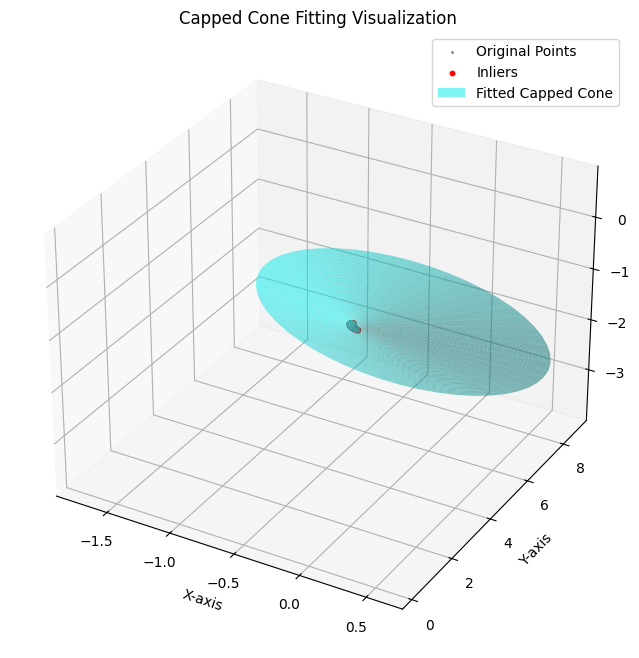

In [48]:
plot_capped_cone(points, cone_inliers, cone_params)

## Visualization

In [39]:
cone_cloud = o3d.geometry.PointCloud()
cone_cloud.points = o3d.utility.Vector3dVector(cone_inliers)
cone_cloud.paint_uniform_color([0,1,0])

#cone_mesh = create_cone_mesh(cone_params
#cone_mesh.paint_uniform_color([0.7, 1, 0.7])

downpcd.paint_uniform_color([0,0,0])

PointCloud with 4084 points.

In [40]:
o3d.visualization.draw_geometries([downpcd, cone_cloud])